## 🔬 Control Dataset Overview

This notebook analyzes spontaneous calcium activity in BxPC3 pancreatic cancer cells imaged under identical control conditions across six image sequences.

**Experimental context:**
- Cell line: BxPC3 (pancreatic ductal adenocarcinoma)
- Imaging: DIV2, seeded at 1.2 million cells per well (high confluence)
- Ca²⁺ dye: Fluo-4 AM (standard loading protocol)
- Nuclei: Hoechst 33342 (10 µg/mL)
- Acquisition: FITC, 1 Hz, 30 ms exposure for 30 minutes

This is the **second run** of spontaneous activity under control conditions. 

**Goal: Determine if the second imaging run can serve as reliable control data or if phototoxicity, photobleaching, or altered culture conditions (room temperature exposure without optimal CO₂ and humidity) have significantly impacted cellular behavior.**

## ⚙️ Setup & Utilities

Standard scientific libraries (Pandas, NumPy, Seaborn) and custom plotting utilities are loaded. These functions enable streamlined metric visualization and layout control across multiple datasets.

In [1]:
# Libraries
import seaborn as sns
import numpy as np
from pathlib import Path
import sys

# Add /Source to sys.path if not already present
project_root = Path.cwd().parent
source_path = project_root / "src"

if source_path.exists() and str(source_path) not in sys.path:
    sys.path.insert(0, str(source_path))

# Utility functions
from calcium_activity_characterization.analysis.visualizers import plot_metric_by_dataset, plot_category_distribution_by_dataset, plot_raster_plots_by_dataset
from calcium_activity_characterization.analysis.loaders import load_and_merge_datasets

sns.set(style="whitegrid")

# Define paths to control datasets
control_paths = {
    "20250326 - IS2": "D:/Mateo/20250326/Output/IS2",
    "20250326 - IS4": "D:/Mateo/20250326/Output/IS4",
    "20250404 - IS2": "D:/Mateo/20250404/Output/IS2",
    "20250409 - IS10": "D:/Mateo/20250409/Output/IS10",
    "20250409 - IS12": "D:/Mateo/20250409/Output/IS12",
}

# Load and merge datasets
peaks = load_and_merge_datasets(control_paths=control_paths, file_name="peaks.csv")
cells = load_and_merge_datasets(control_paths=control_paths, file_name="cells.csv")
events = load_and_merge_datasets(control_paths=control_paths, file_name="events.csv")

## 🧼 Preprocessing

Before visual comparison, we normalize event labels (e.g., missing `in_event` entries set to `'individual'`) and compute additional derived fields (`is_active`, `periodicity_score`) to ensure consistent comparisons across all datasets.

These steps are crucial for **ensuring fair metric aggregation** and enabling downstream comparative analysis.

In [2]:
peaks["in_event"] = peaks["in_event"].fillna("individual").str.lower()

if "is_active" not in cells.columns:
    cells["is_active"] = cells["num_peaks"].apply(lambda x: 1 if x > 0 else 0)

if "periodicity_score" not in cells.columns:
    cells["periodicity_score"] = np.nan

## 🖼️ Raster Plot Inspection

Raster plots provide a binary overview of calcium activity over time per cell.

*Remarks:* 
*TODO*

📌 Use these plots to **screen visually for anomalies or batch effects** before statistical analysis.

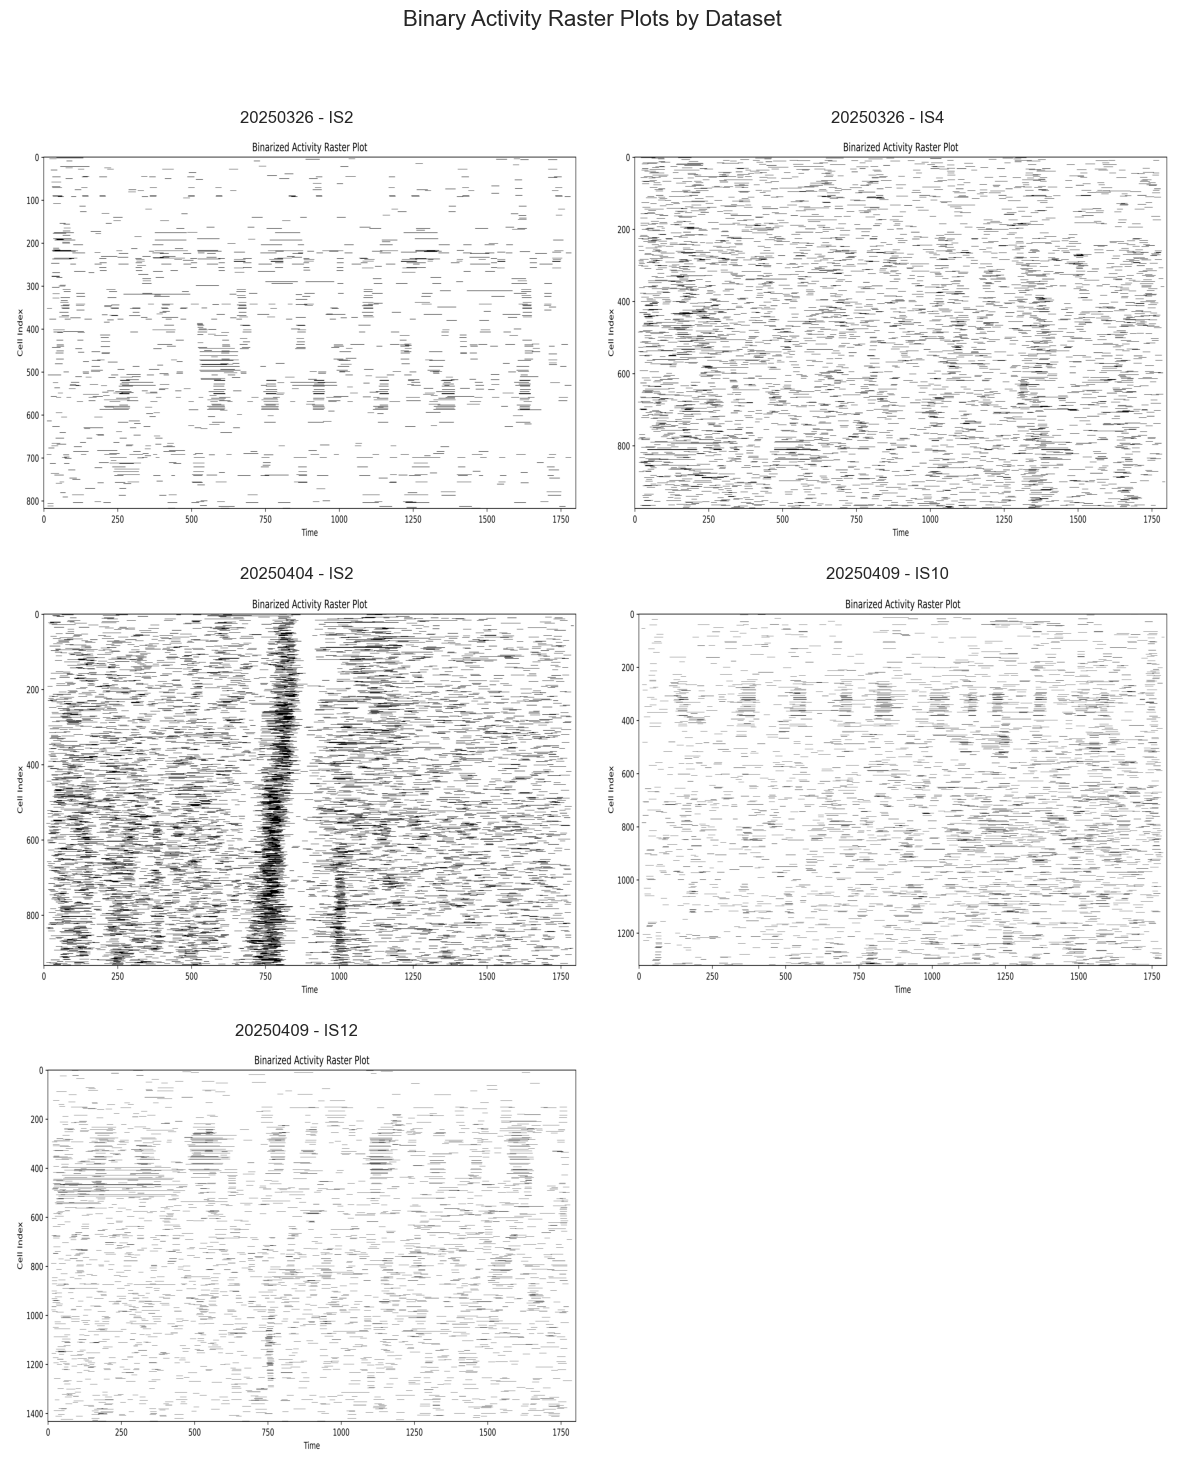

In [3]:
plot_raster_plots_by_dataset(
    dataset_paths=control_paths,
    title="Binary Activity Raster Plots by Dataset"
)

## 📊 Peak Type Distribution

Pie charts quantify the proportion of detected calcium peaks classified as:
- `individual`: isolated peaks
- `sequential`: propagating local events
- `global`: large-scale synchronized events

*Interpretation:*

*The second imaging run displays striking differences compared to the first.*

- *Global events are almost entirely absent, with 4 out of 5 datasets showing **no global events**. Only one dataset (`2025-04-04 IS3`) exhibited minimal global activity.*

- *Sequential and individual peaks maintain a similar ratio compared to the first run, but the absence of global events indicates an altered system-wide behavior.*

*This suggests a breakdown of coordinated signaling mechanisms, likely caused by phototoxicity or environmental stress.*

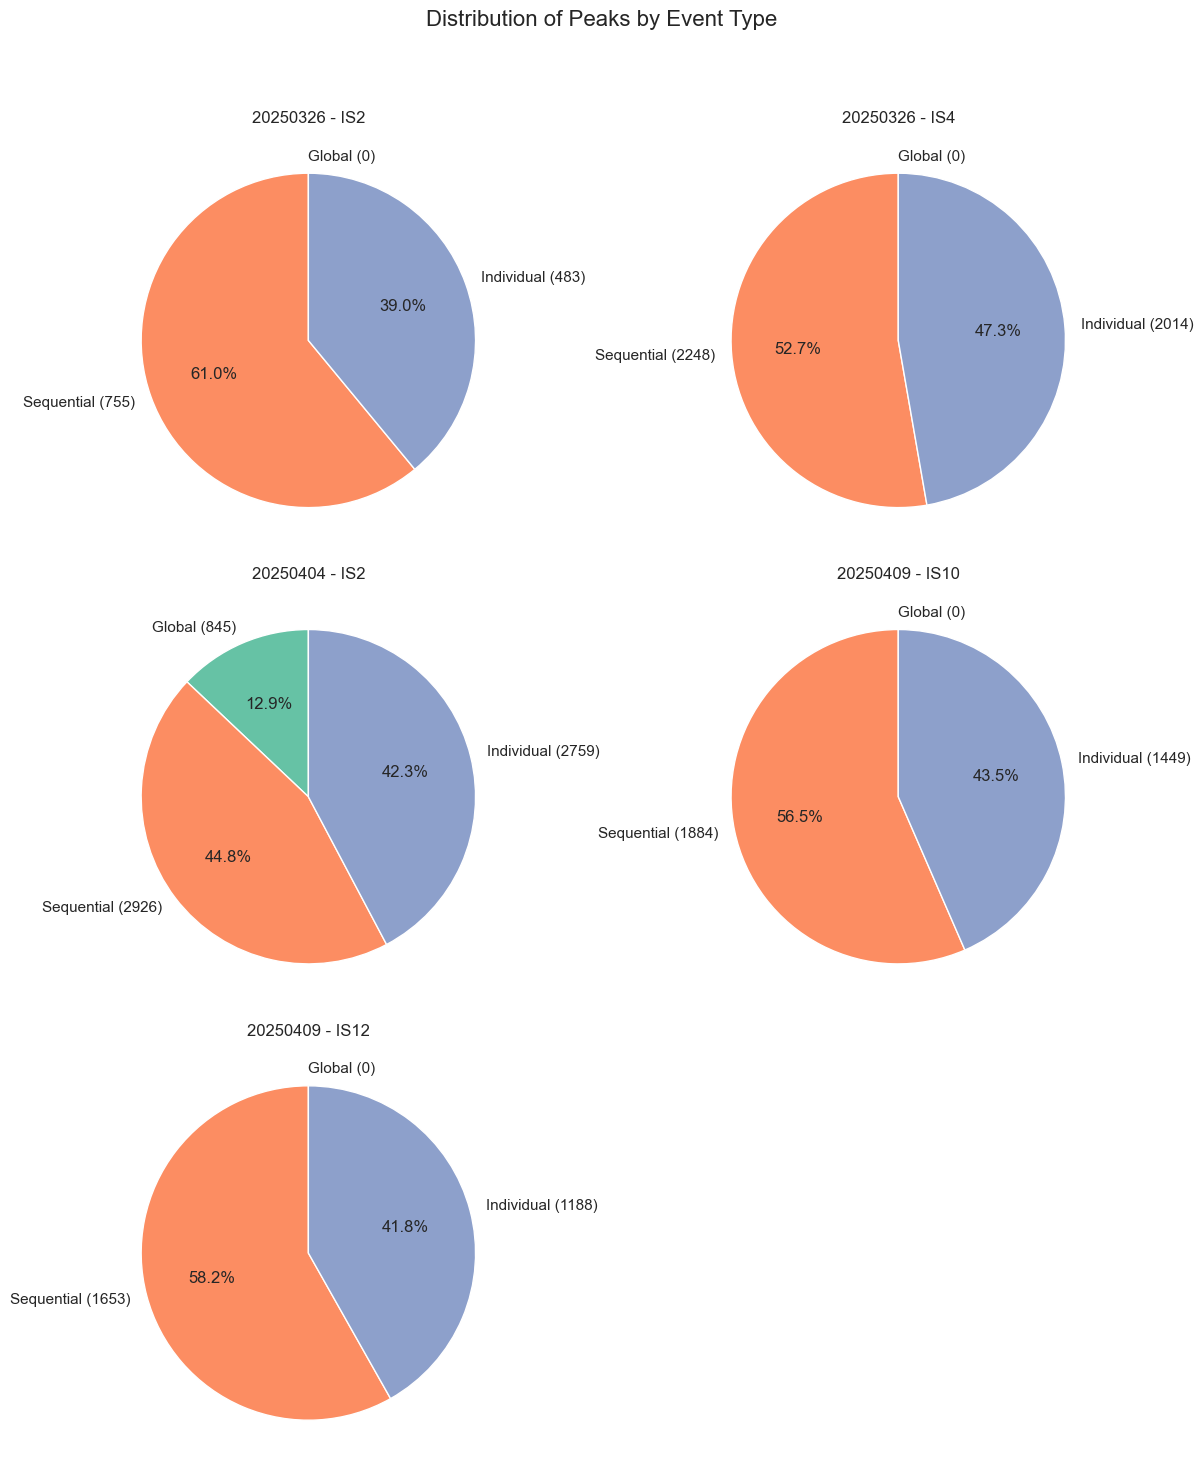

In [4]:
peak_type_colors = {
    "global": "#66c2a5",
    "sequential": "#fc8d62",
    "individual": "#8da0cb"
}

plot_category_distribution_by_dataset(
    df=peaks,
    column="in_event",
    category_order=["global", "sequential", "individual"],
    colors=peak_type_colors,
    title="Distribution of Peaks by Event Type"
)

## 📈 Peak Metrics per Event Type

Metrics like **duration**, **prominence**, and **symmetry** are visualized per event type.  

*Interpretation:*

- *Global peaks: Only present in one dataset; insufficient for analysis.*

- *Sequential peaks: Slightly longer durations (~33 frames) than in First Run; symmetry remains consistent (~0.9 ± 0.12).*

- *Individual peaks: Also slightly longer (~30 frames), with similar symmetry.*

*These longer durations might result from subtle shifts in intracellular calcium handling, possibly caused by phototoxic stress or under-detection of broad events misclassified as individual.*


#🔍 Peak Type: Global — 845 peaks


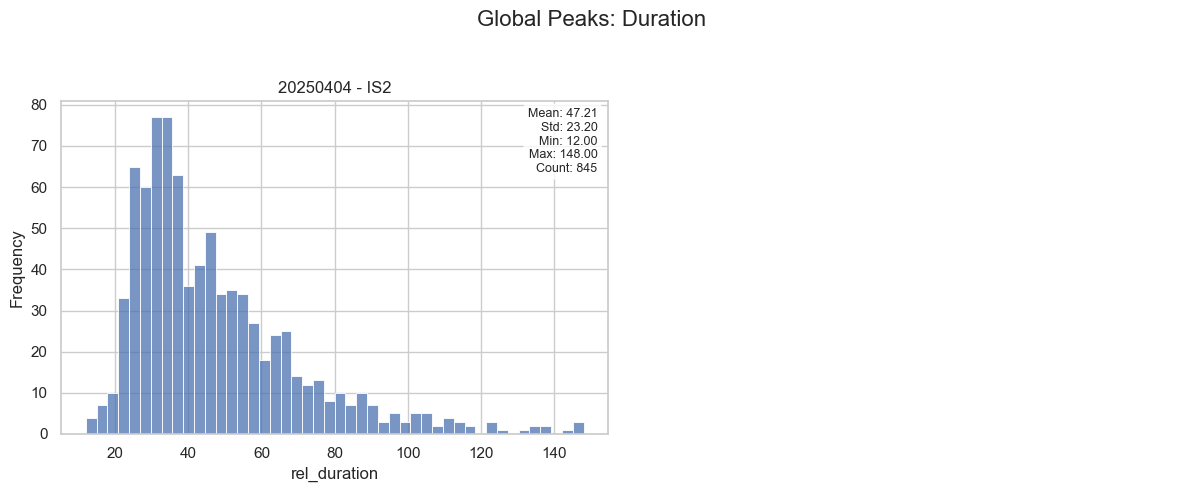

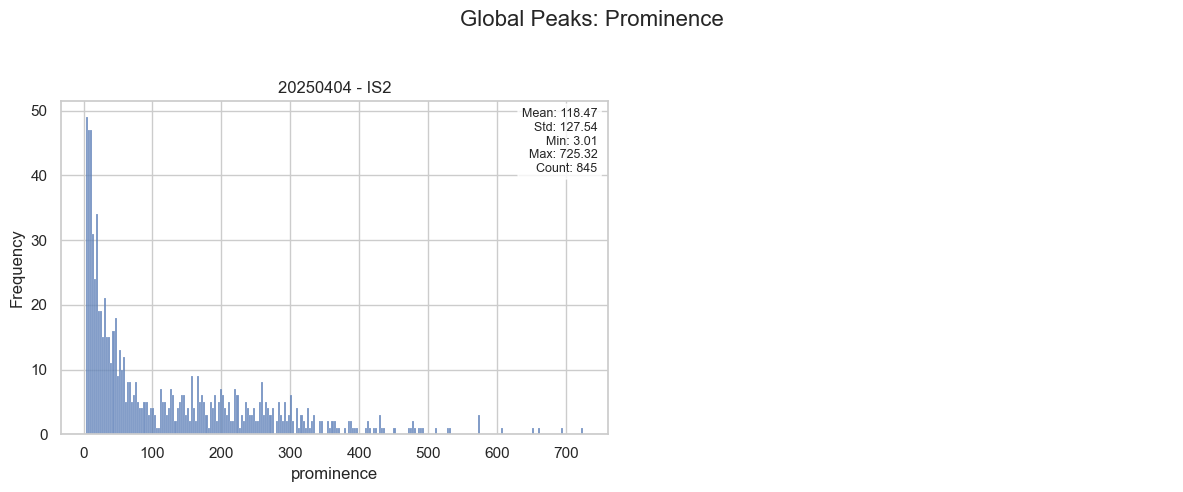

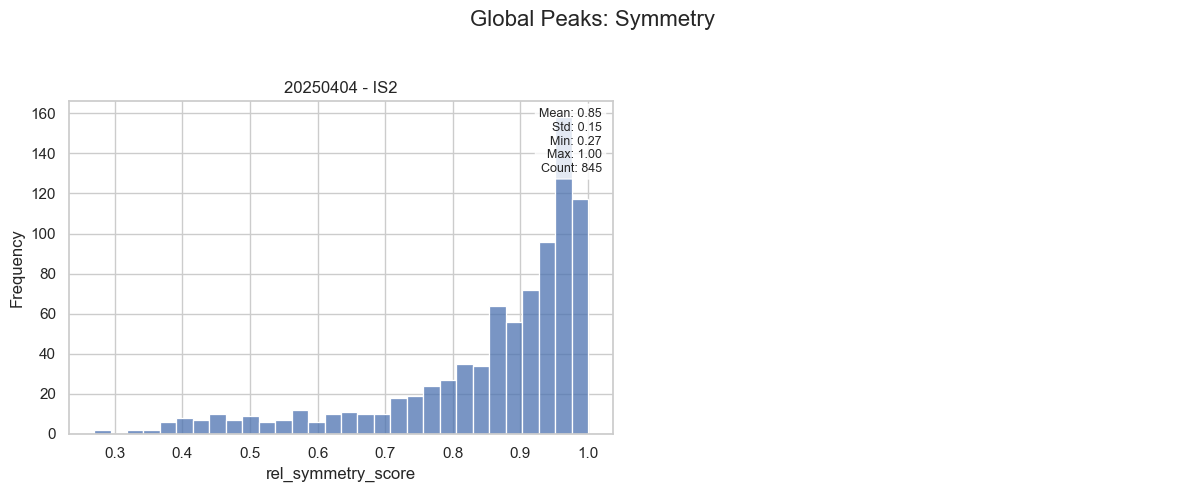


#🔍 Peak Type: Sequential — 9466 peaks


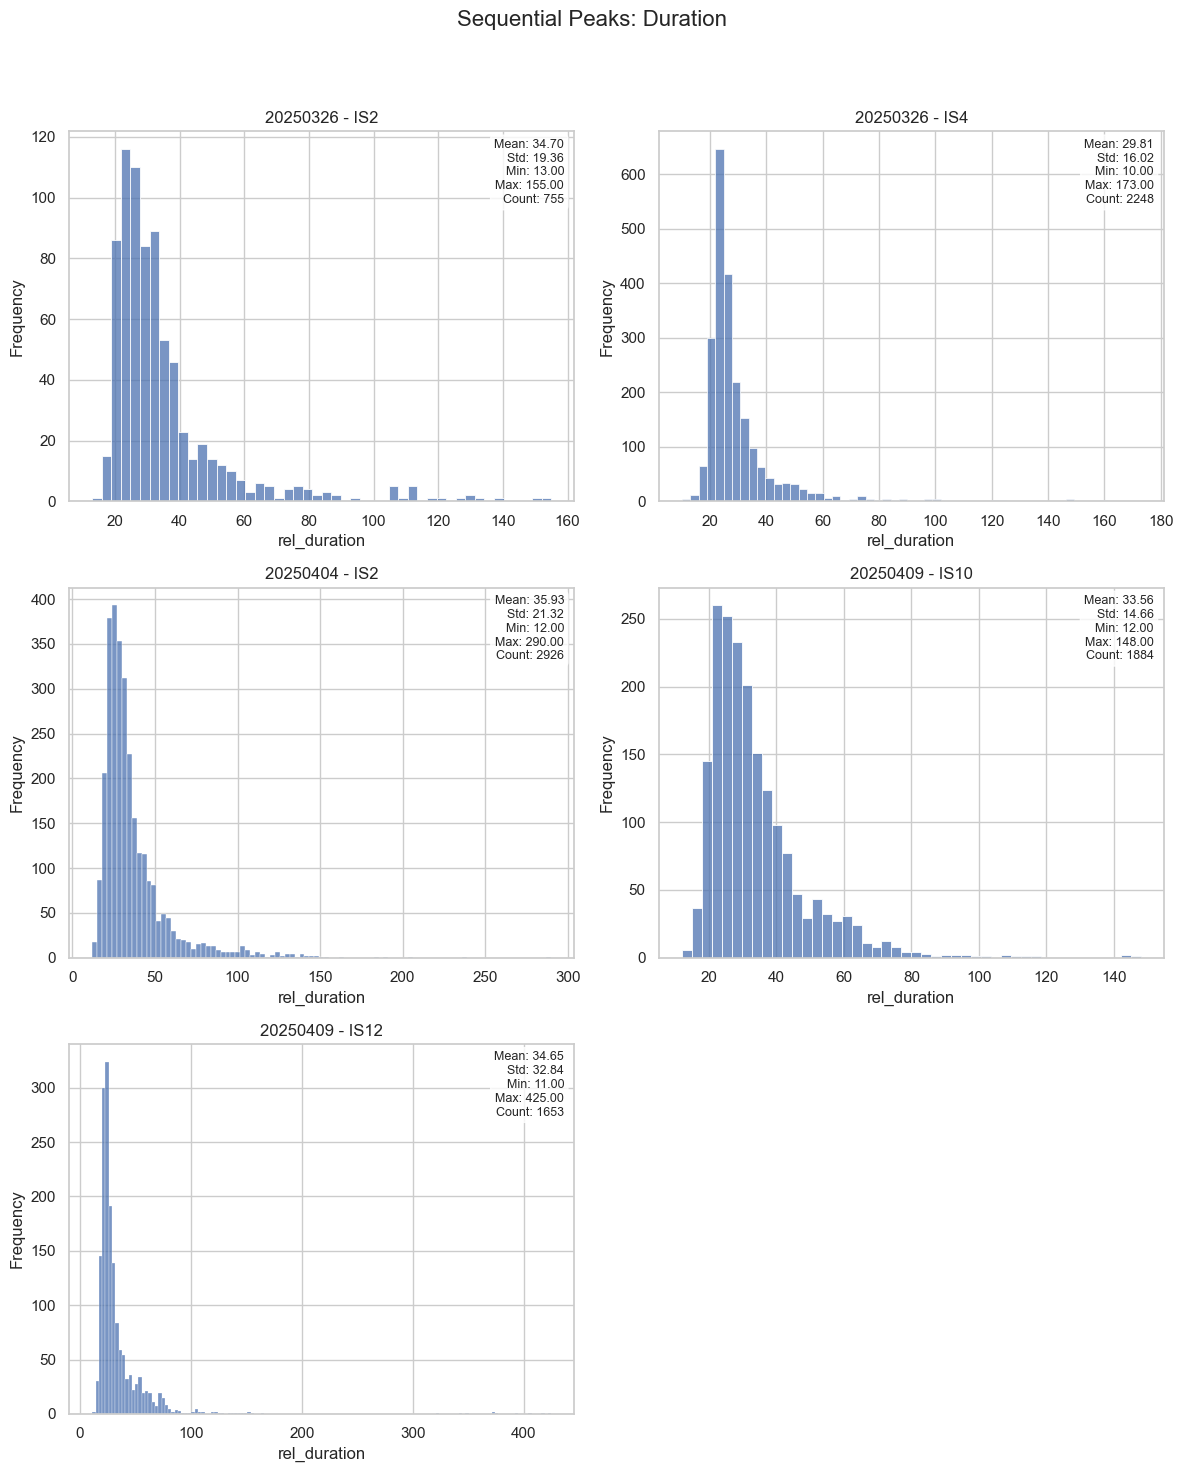

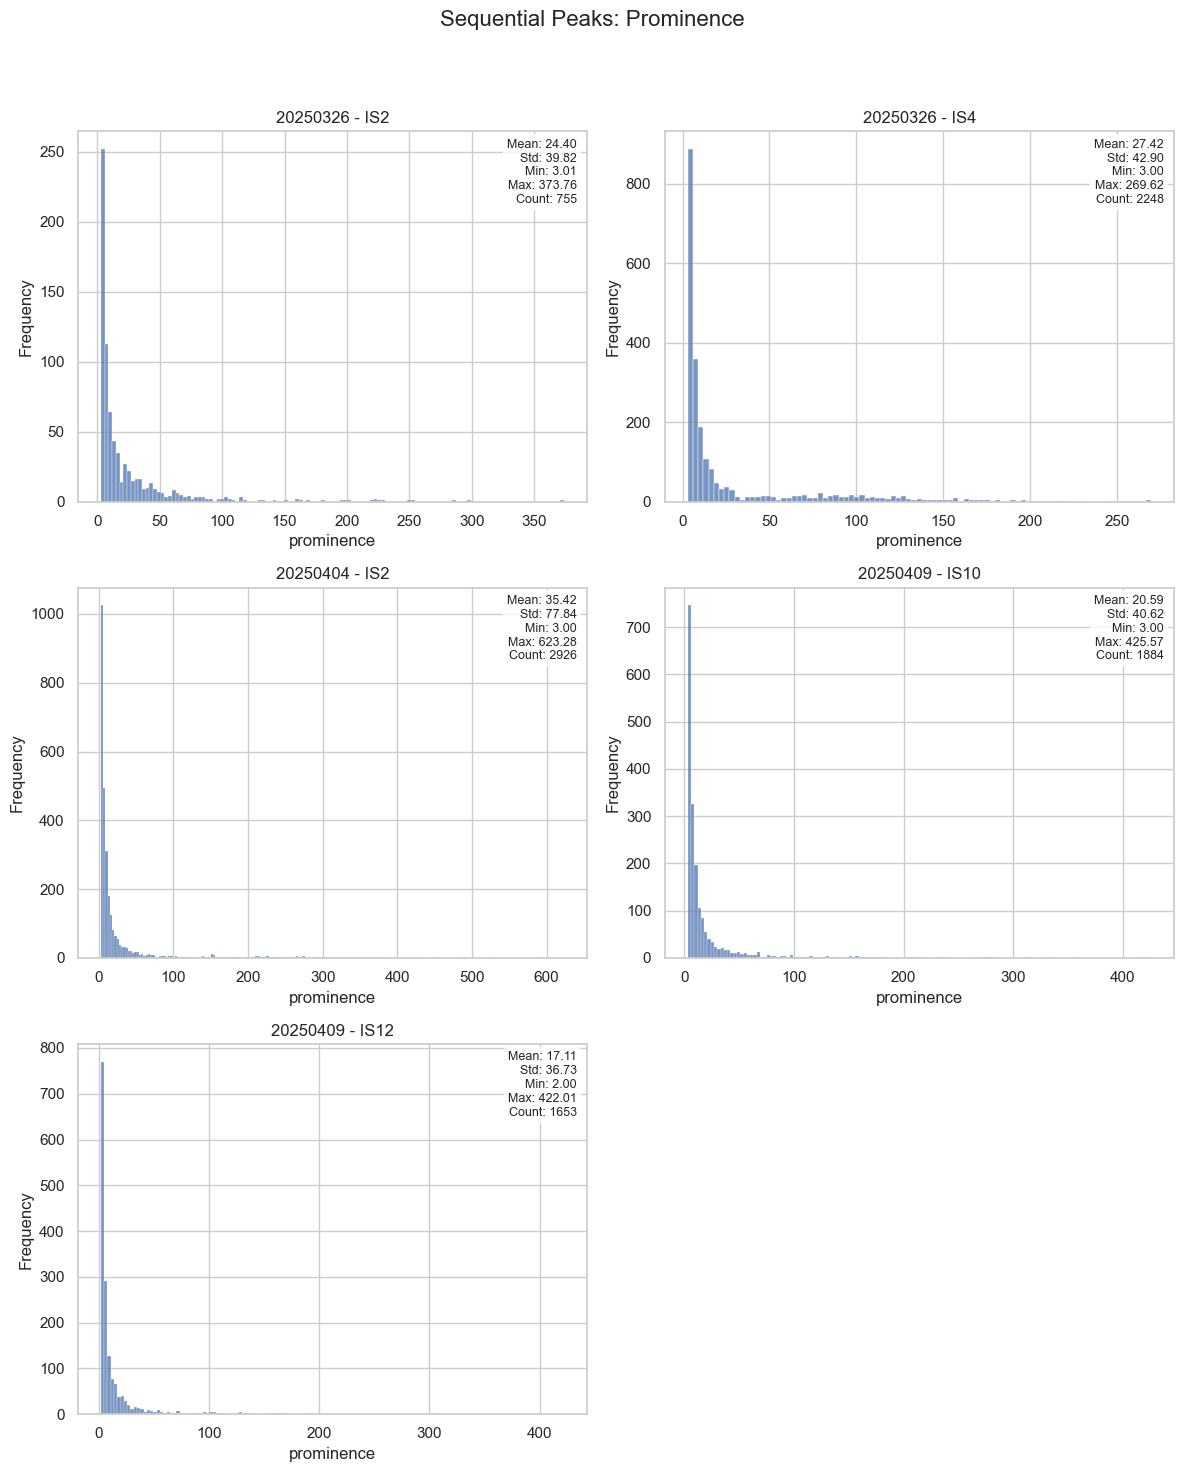

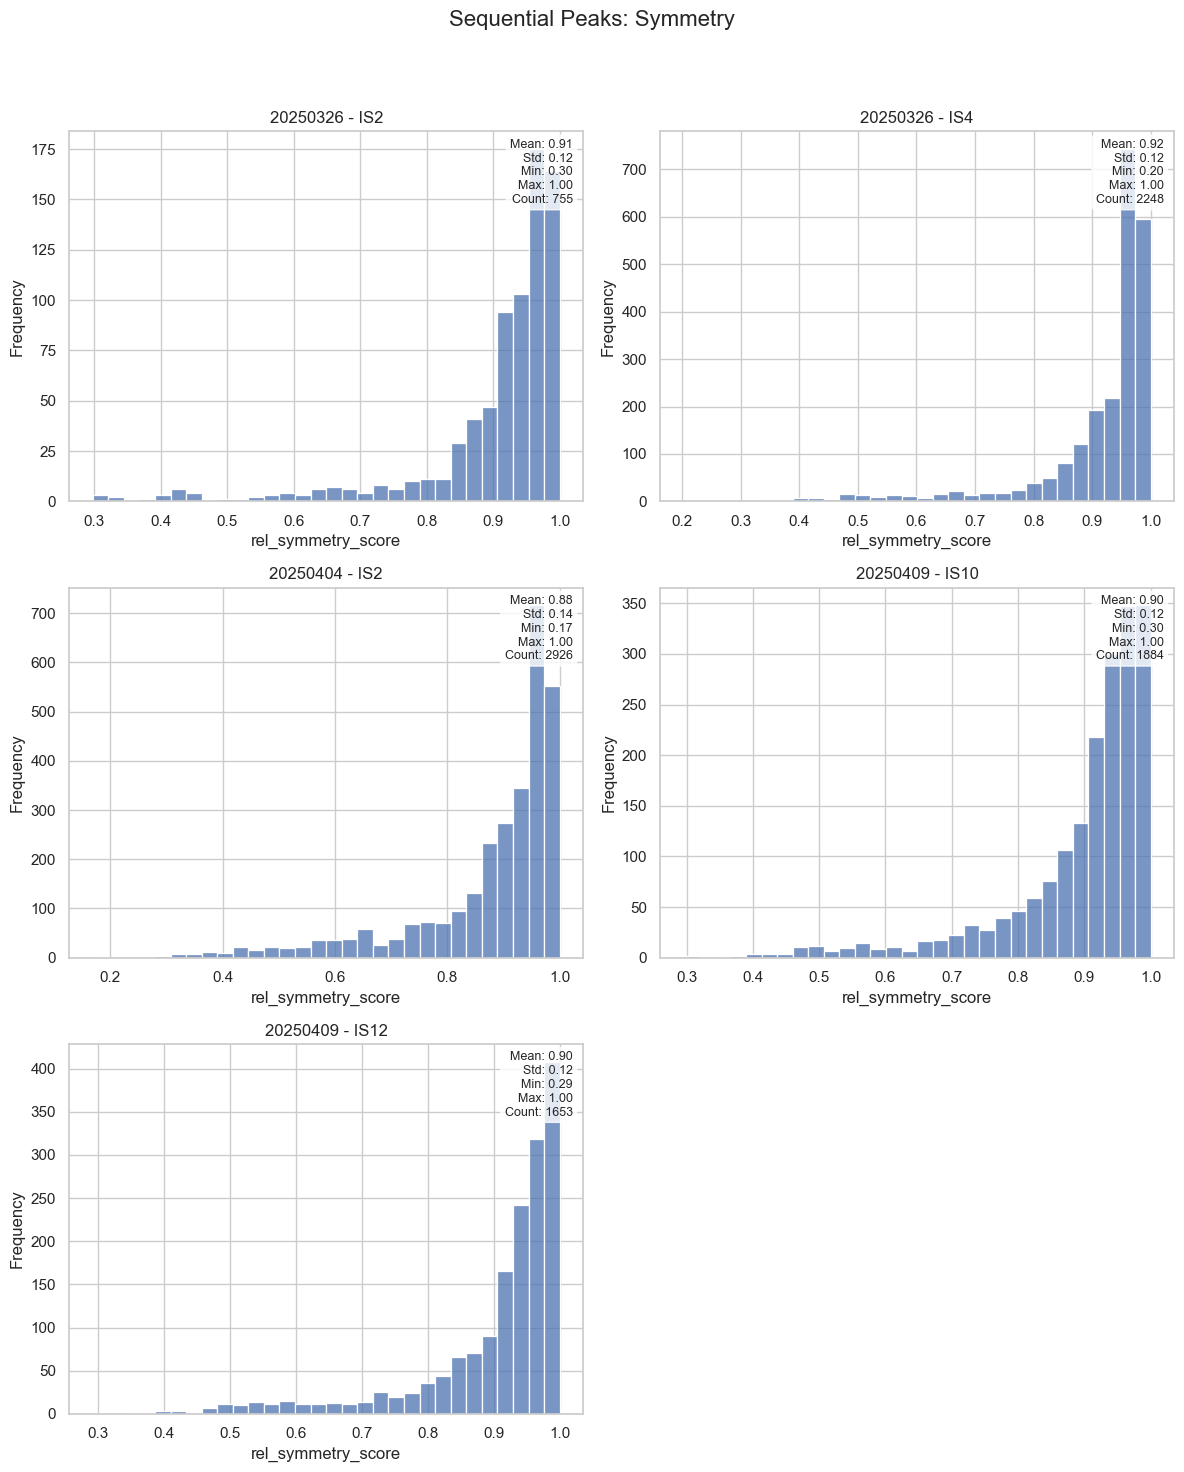


#🔍 Peak Type: Individual — 7893 peaks


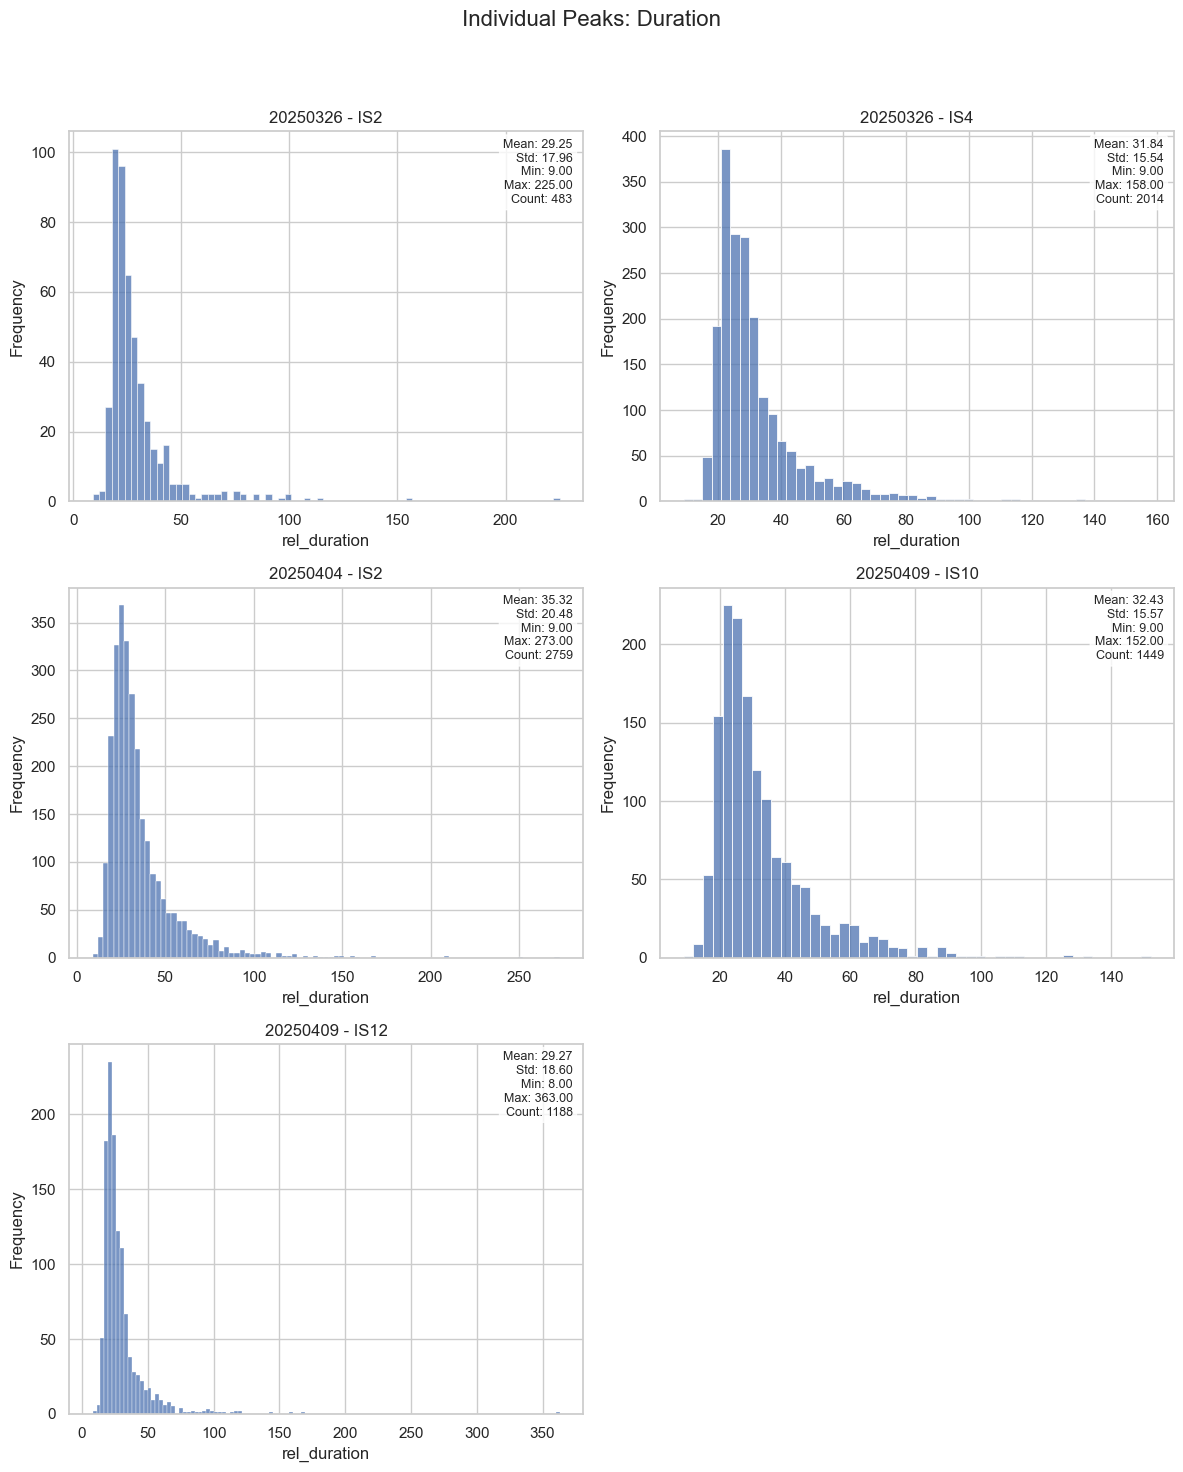

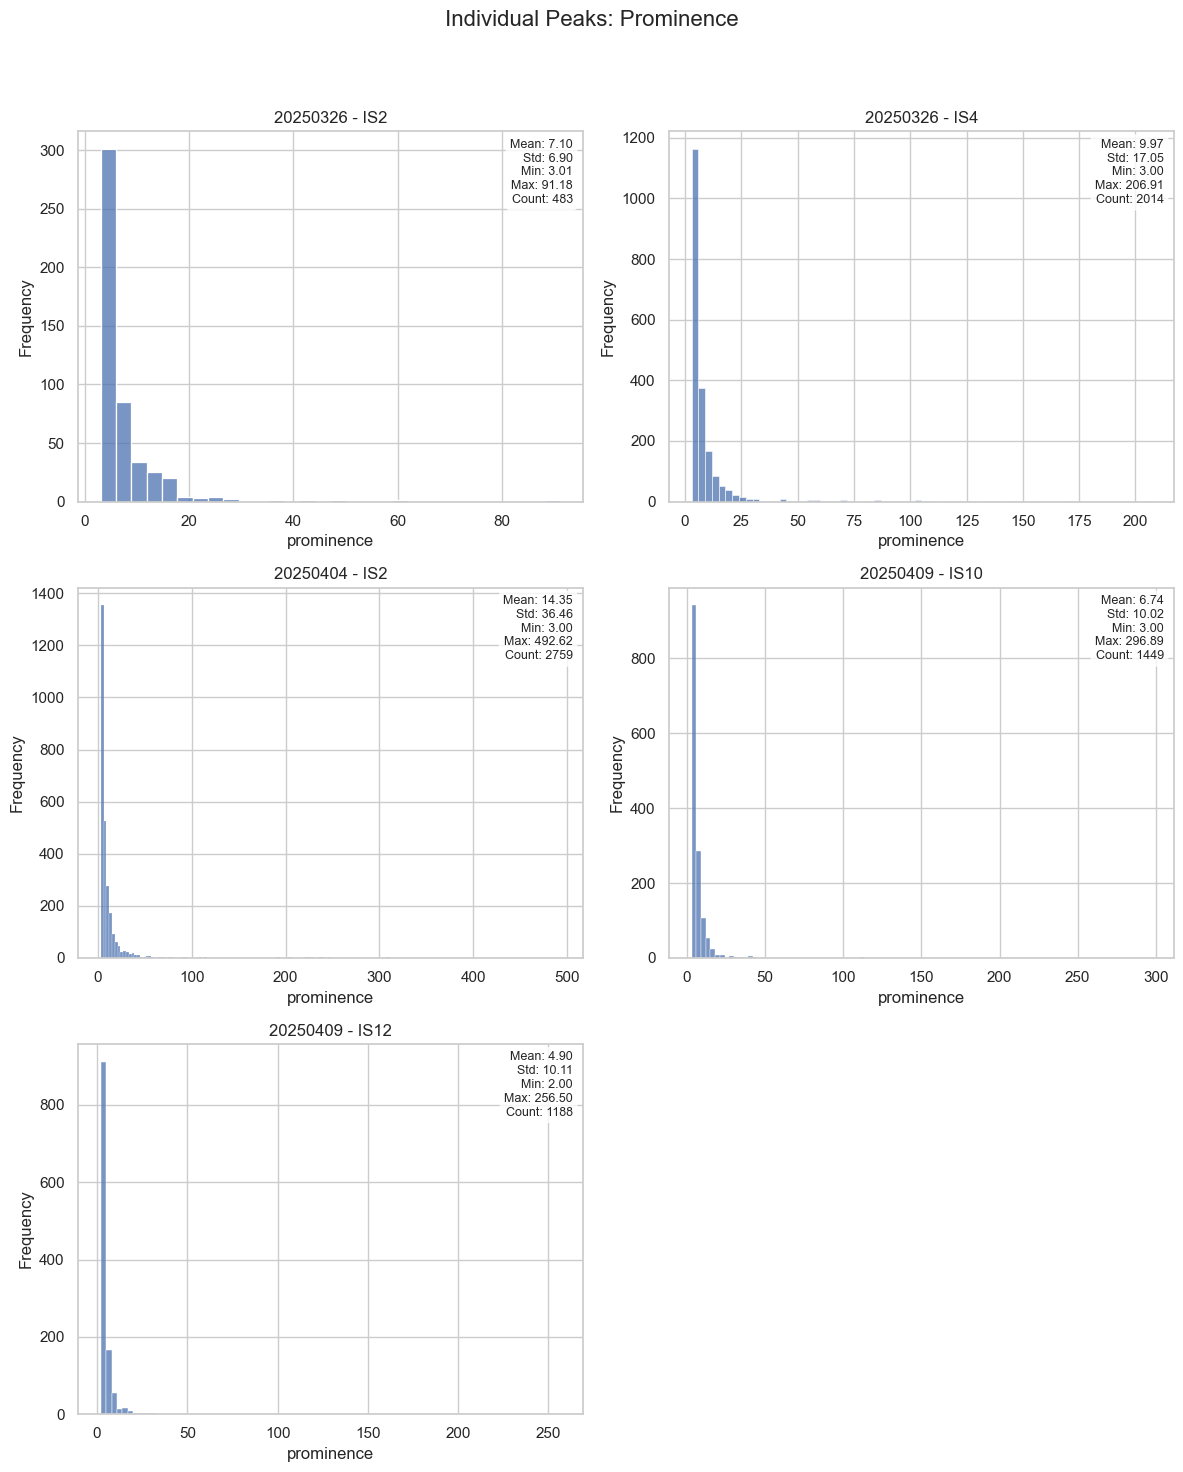

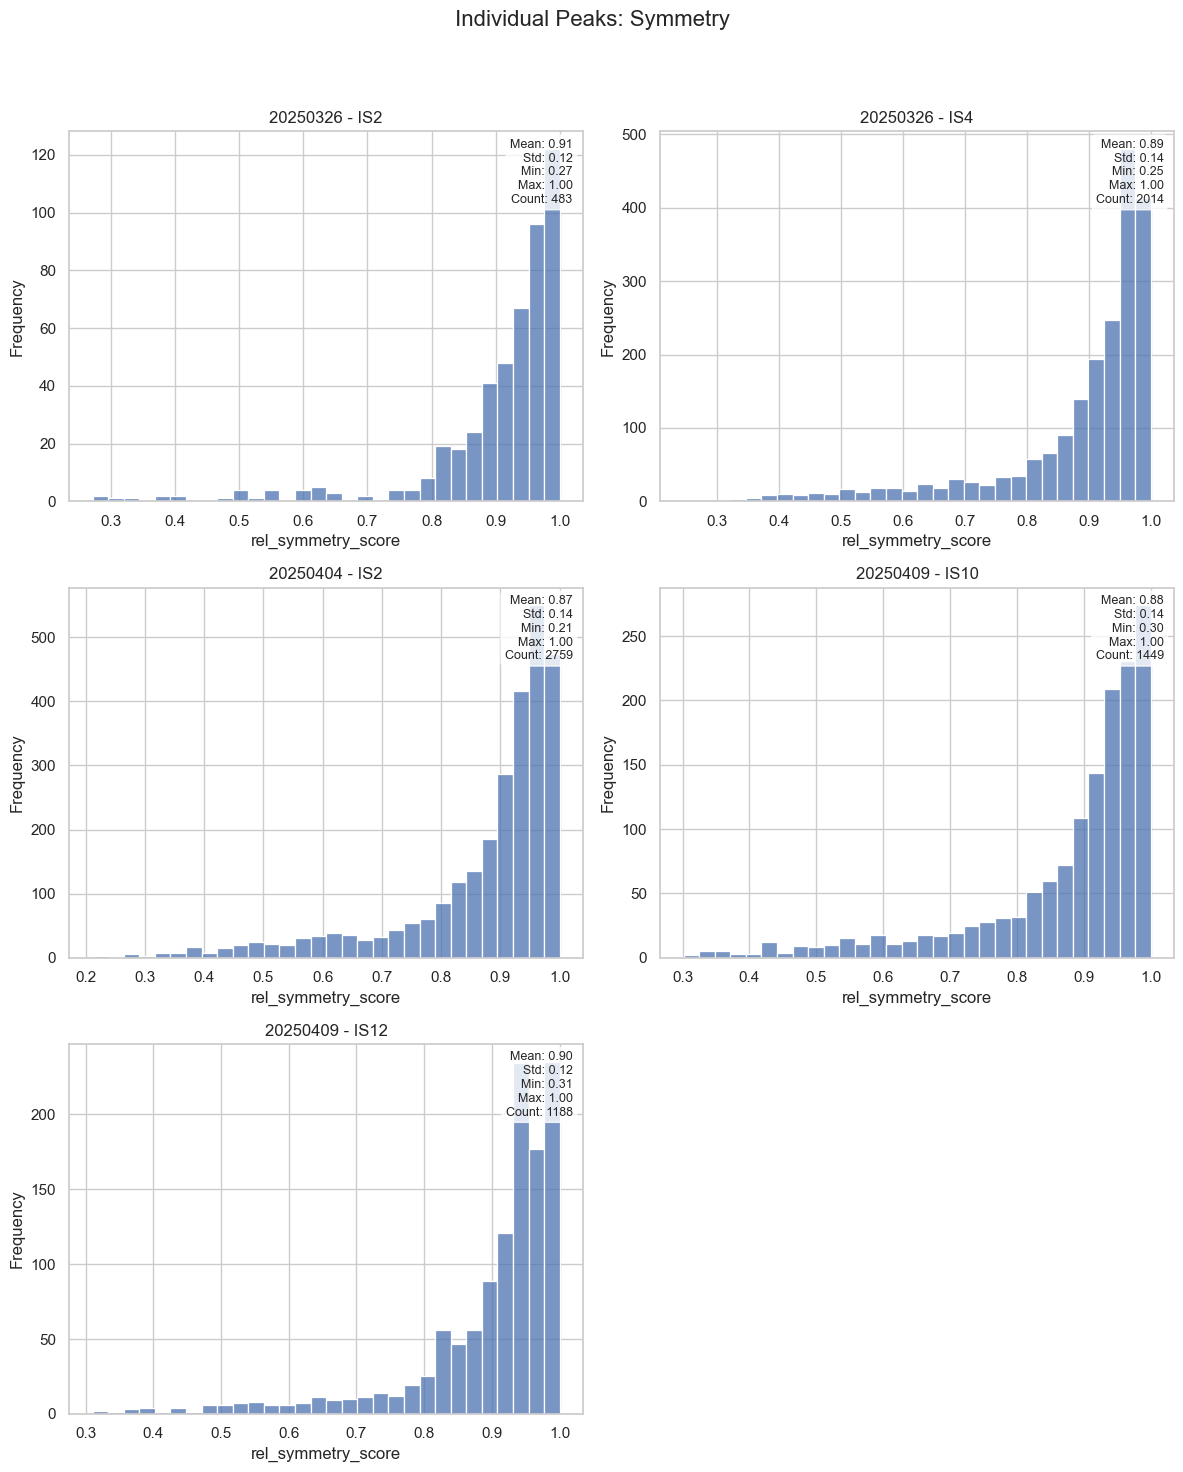

In [5]:

for event_type in ["global", "sequential", "individual"]:
    subset = peaks[peaks["in_event"] == event_type]
    print(f"\n#🔍 Peak Type: {event_type.title()} — {len(subset)} peaks")
    plot_metric_by_dataset(subset, "rel_duration", f"{event_type.title()} Peaks: Duration", bin_width=3)
    plot_metric_by_dataset(subset, "prominence", f"{event_type.title()} Peaks: Prominence", bin_width=3)
    plot_metric_by_dataset(subset, "rel_symmetry_score", f"{event_type.title()} Peaks: Symmetry", bin_count=30)

## 🧬 Cell Metrics

We analyze:
- Number of peaks per cell (activity)
- Periodicity score (oscillatory behavior)
- Proportion of active vs inactive cells

*Interpretation:*

*Active cells:* 
*Active cell fraction is significantly lower and more variable (10%–50% inactive).*
*Only the dataset containing a global event exhibits >99% active cells.*
*This suggests that only a subset of cells remains responsive, potentially those participating in larger coordinated events.*
*This change may be due to phototoxicity, room temperature exposure, or photobleaching leading to reduced responsiveness.*

*Number of peaks per cell:*
*Significant reduction in total peak count (1,000–4,000 per dataset).*
-*Distribution shifts to an exponential decay pattern, rather than normal.*
*Only the one dataset with global activity shows similar activity levels to the first run.*
*The altered distribution strongly suggests reduced overall excitability, possibly from Fluo-4 photobleaching or environmental stress.*

*Periodicity:*
*Periodicity scores (~0.7 ± 0.1) remain consistent across both imaging runs.*
*This suggests that rhythmic calcium oscillations are preserved, even when global excitability drops.*

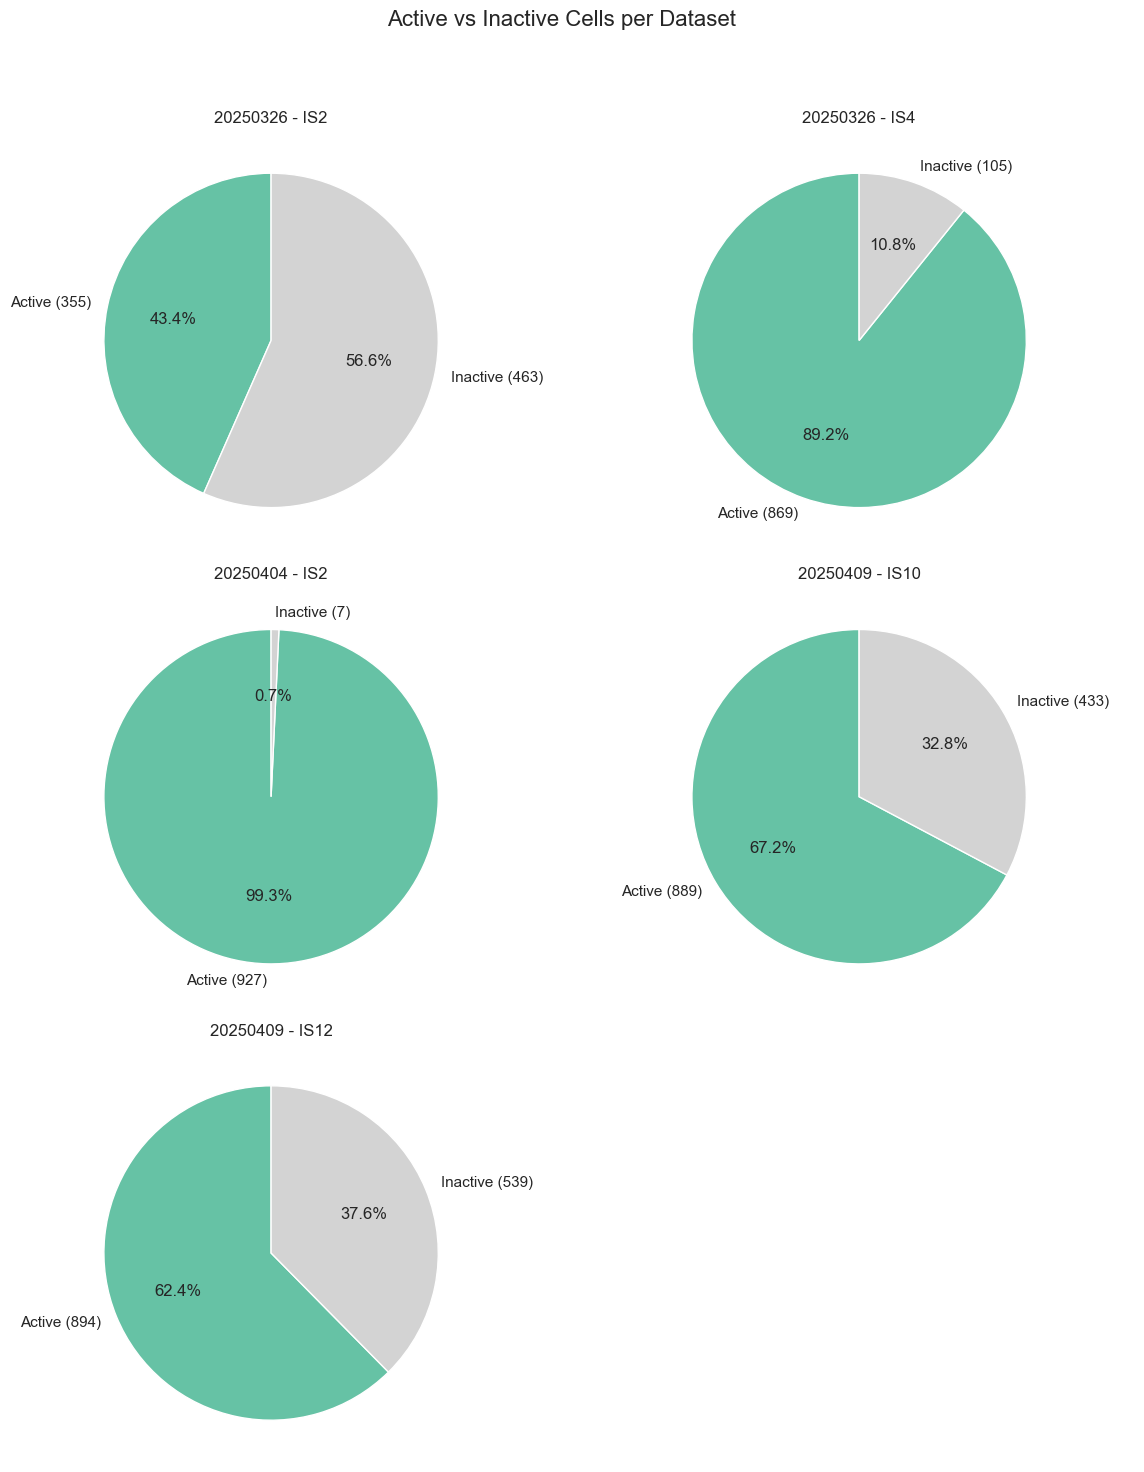

In [6]:
# Convert is_active to label for display purposes
cells["active_label"] = cells["is_active"].map({1: "Active", 0: "Inactive"})

plot_category_distribution_by_dataset(
    df=cells,
    column="active_label",
    category_order=["Active", "Inactive"],
    colors={"Active": "#66c2a5", "Inactive": "#d3d3d3"},
    title="Active vs Inactive Cells per Dataset"
)

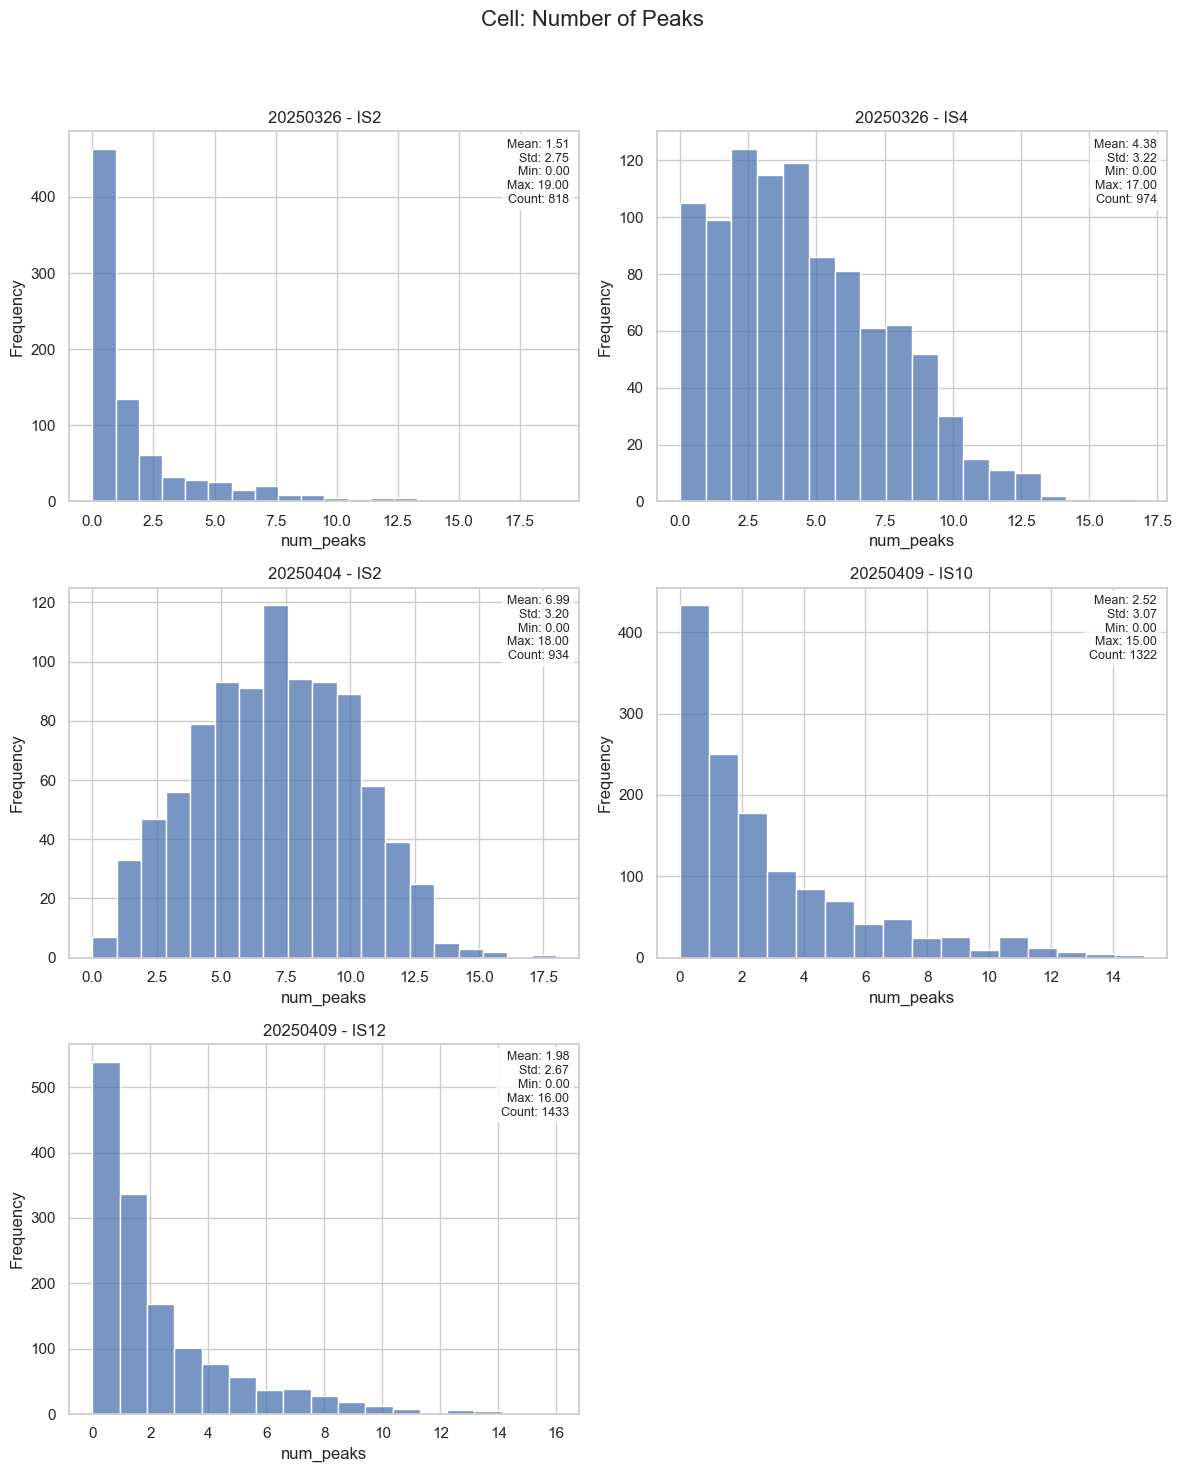

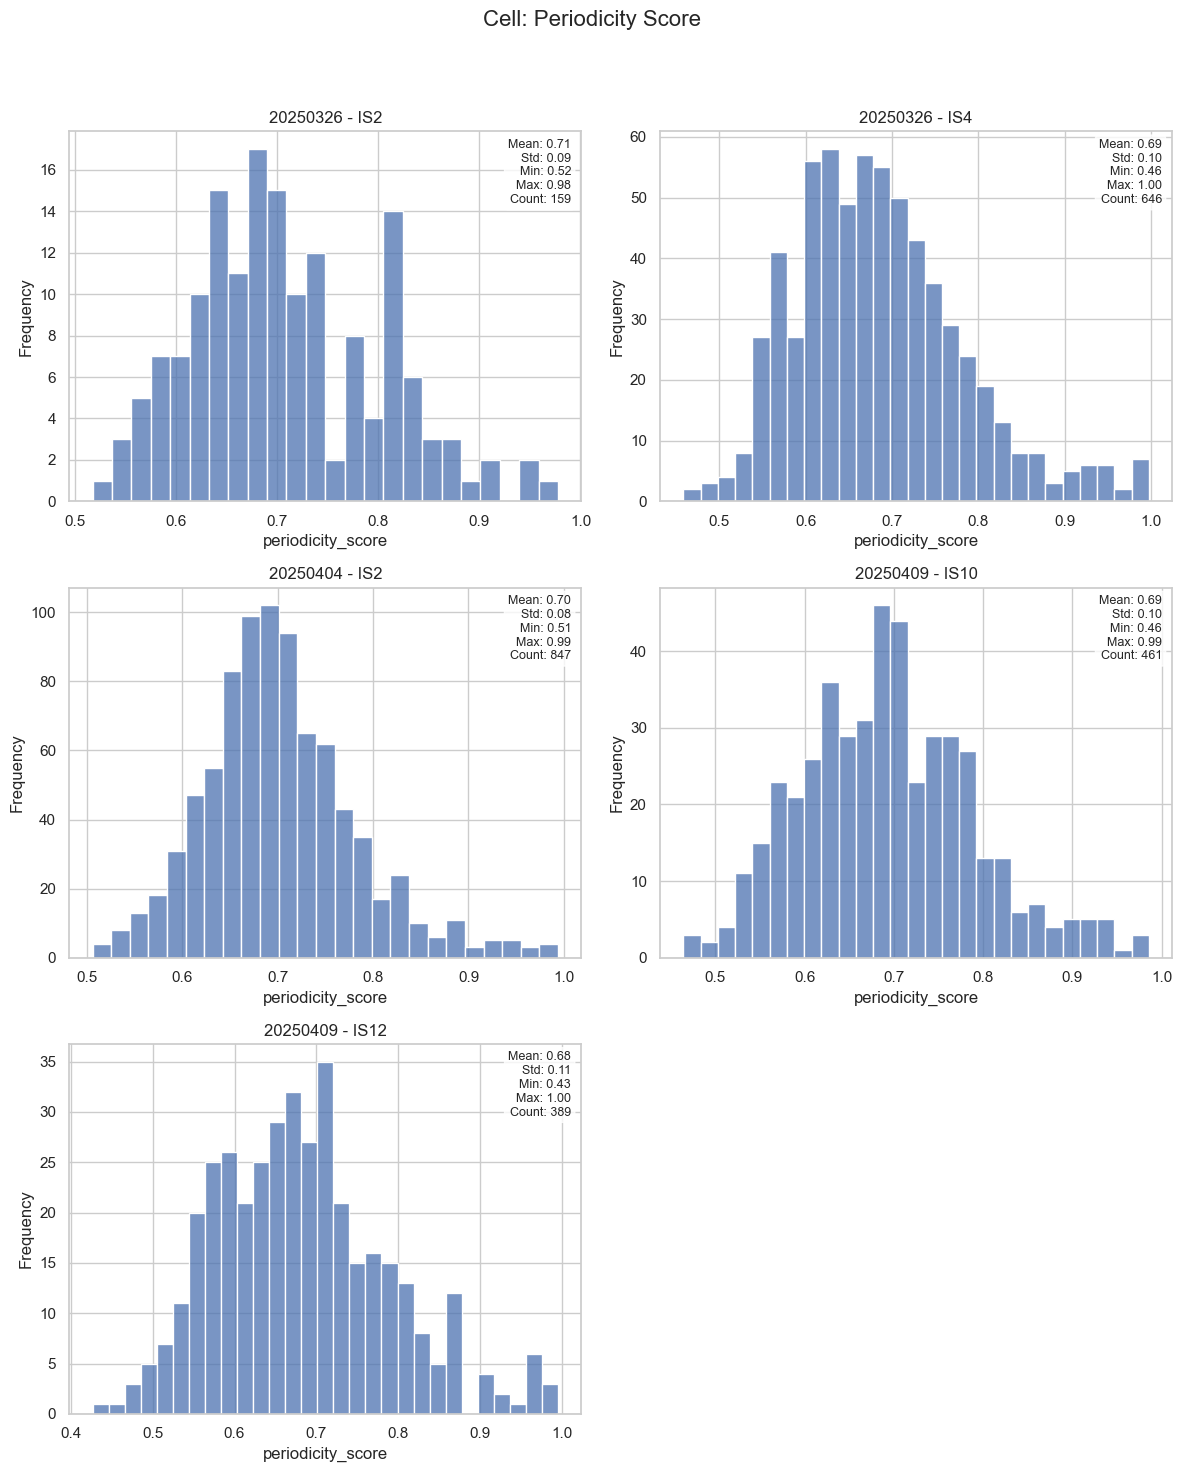

In [7]:
plot_metric_by_dataset(cells, "num_peaks", "Cell: Number of Peaks", bin_width=1)
plot_metric_by_dataset(cells, "periodicity_score", "Cell: Periodicity Score", bin_width=0.02)

## 🌊 Sequential Event Metrics

We focus on **spatiotemporal events**, extracting:
- Mean communication time and speed
- Geometric descriptors (elongation, radiality)
- Graph depth, number of involved cells

*Interpretation:*

- *Communication time: Slightly shorter (means between 2.5 and 4.5), with more variation.*
- *Speed: Slightly higher (~16–18), but similar spread.*
- *Cells involved: Unchanged (~3.2 ± 2).*

*These findings indicate that sequential event mechanisms persist but may occur under altered physical or signaling constraints.*

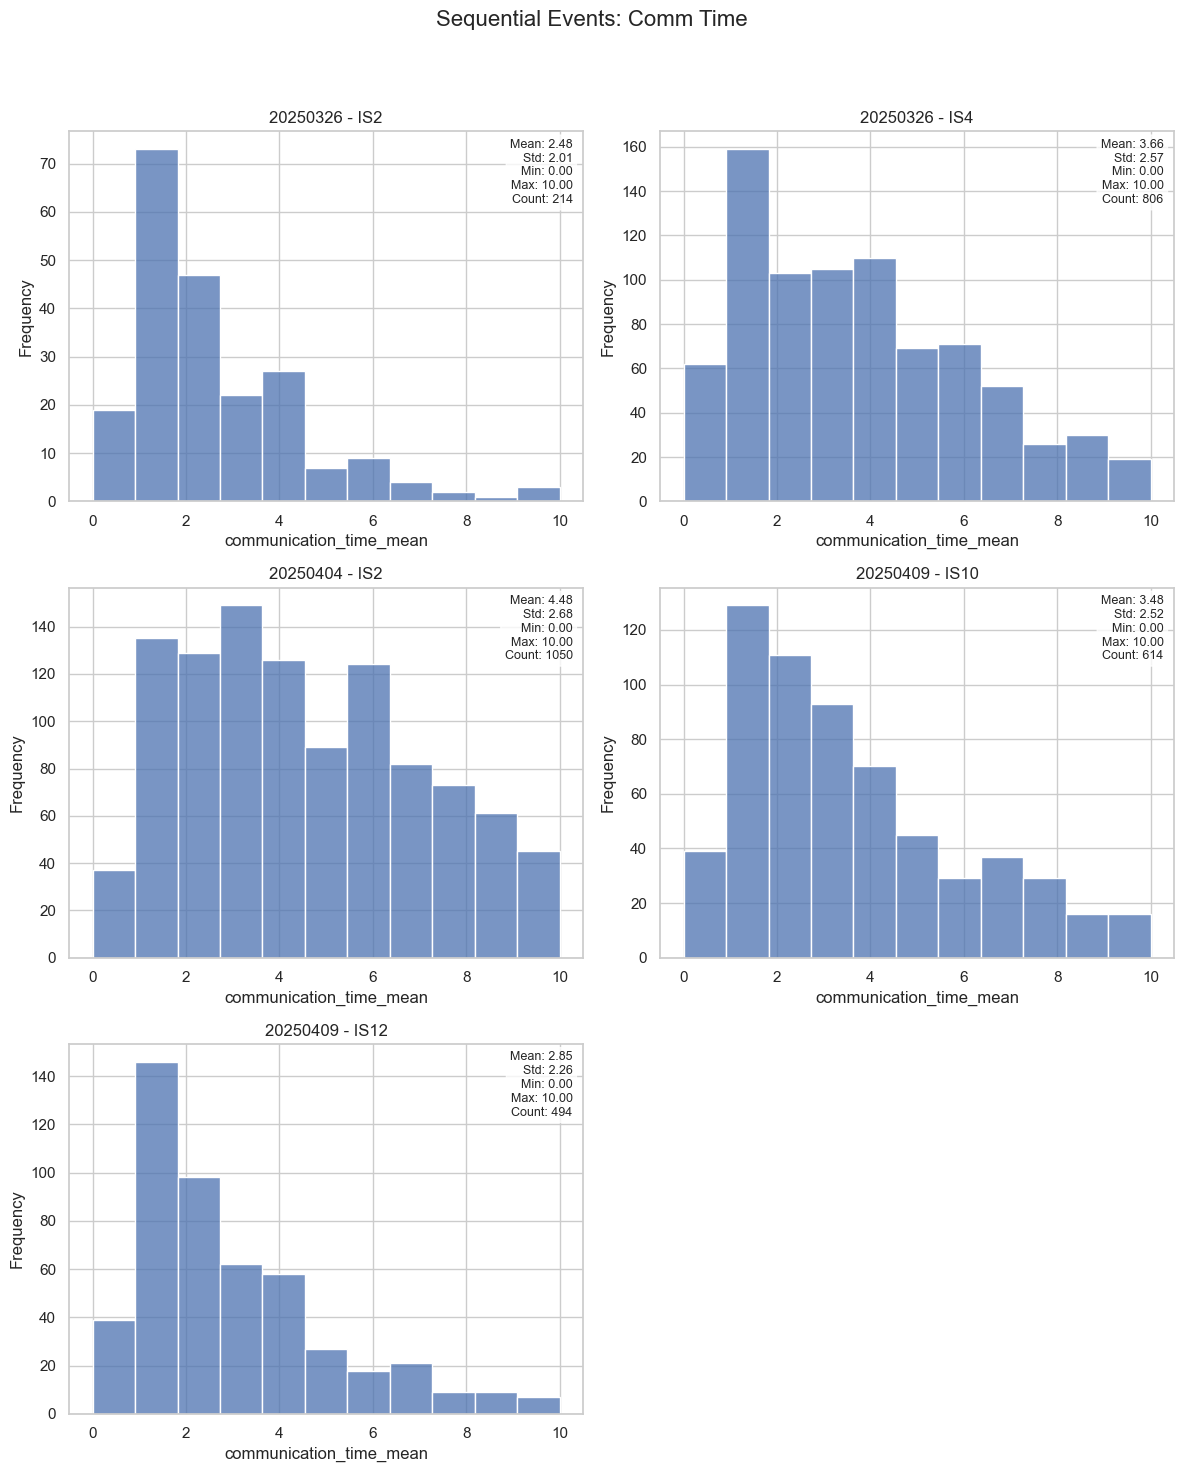

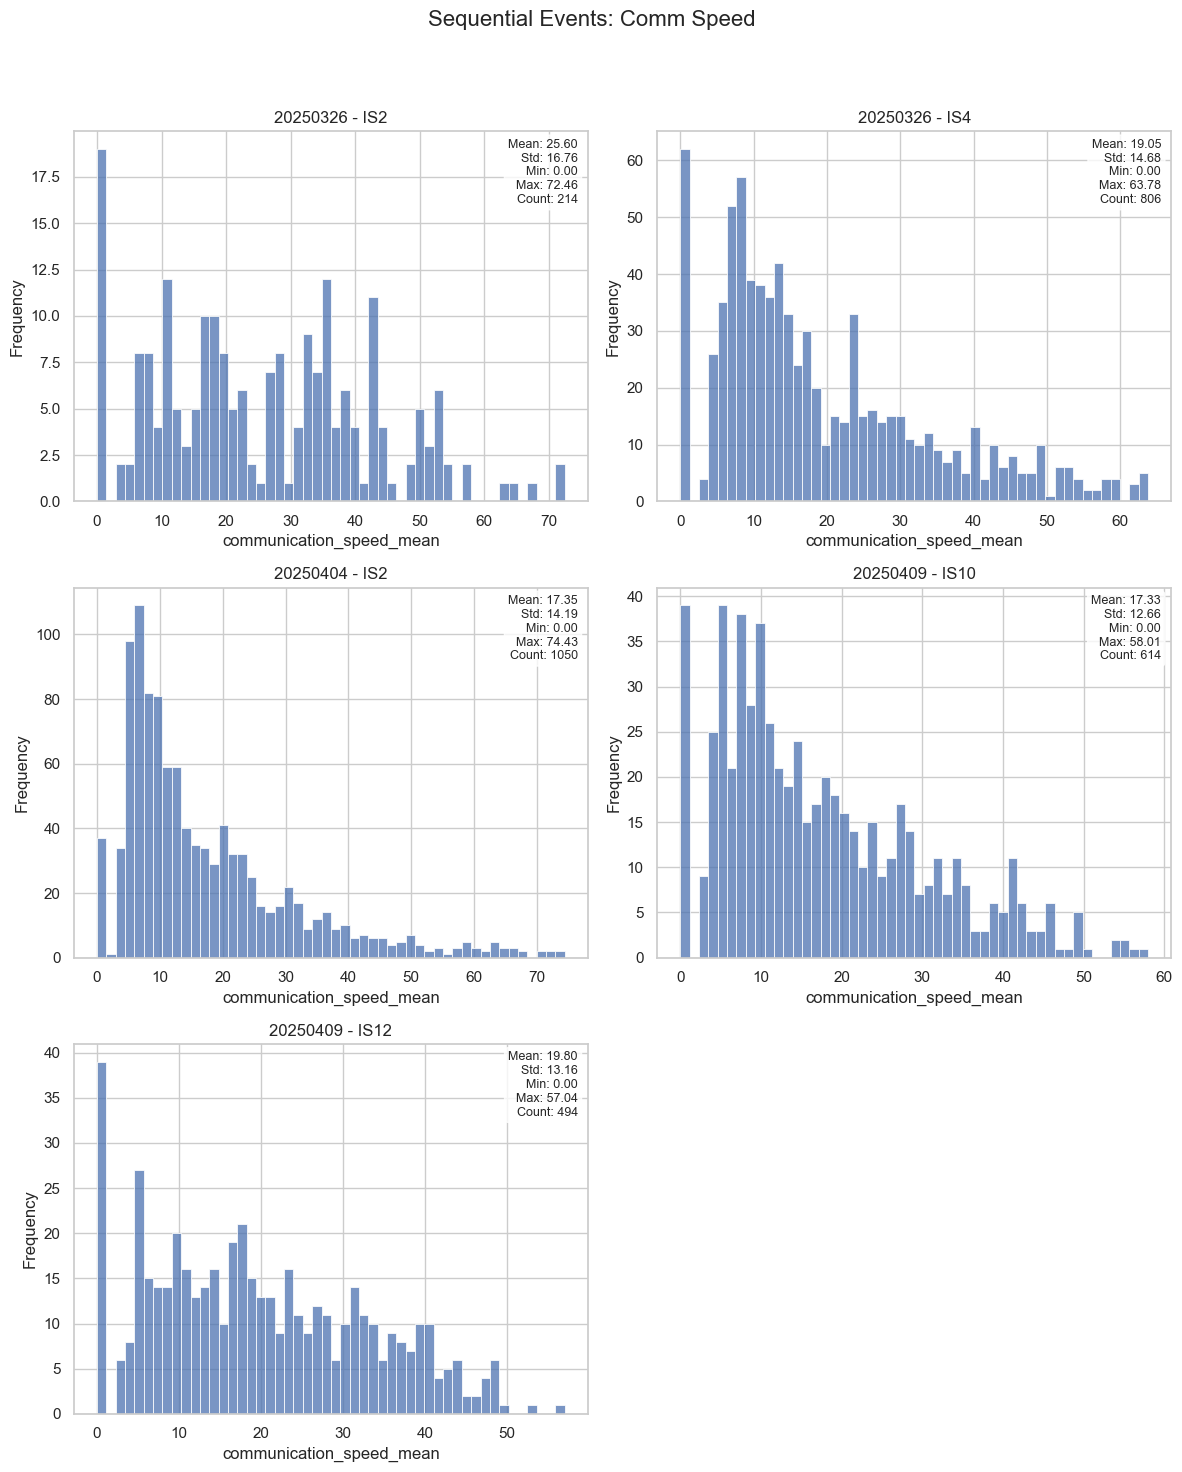

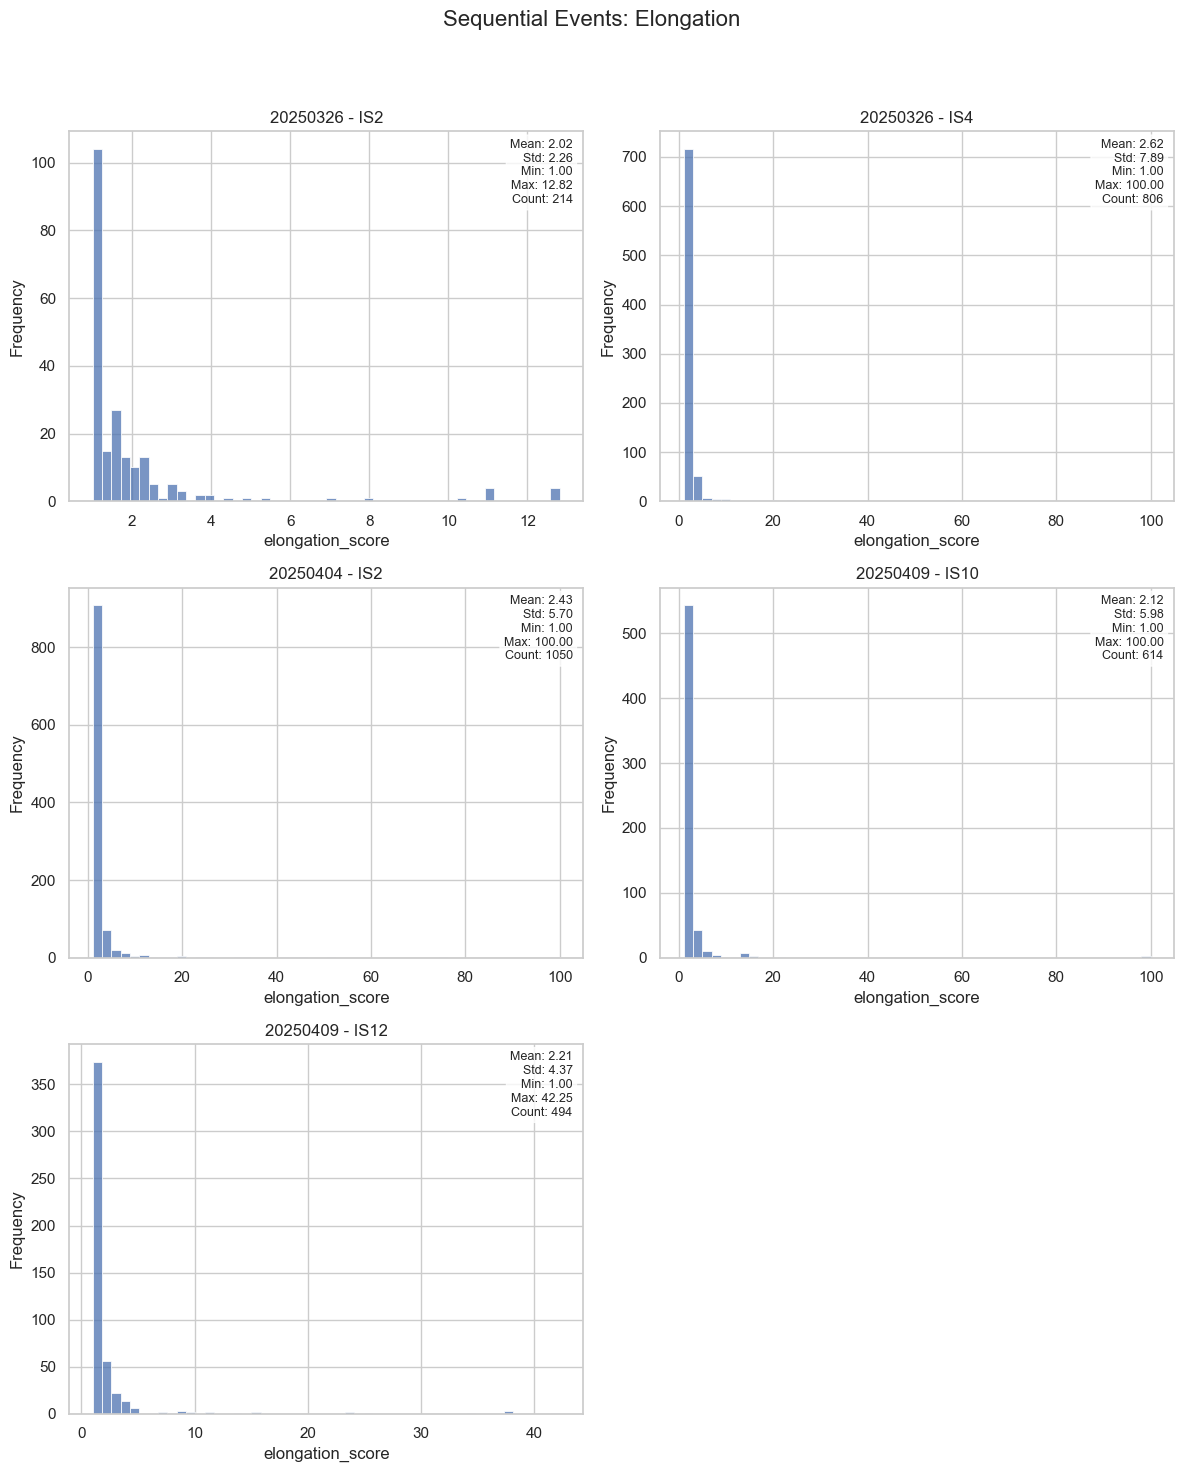

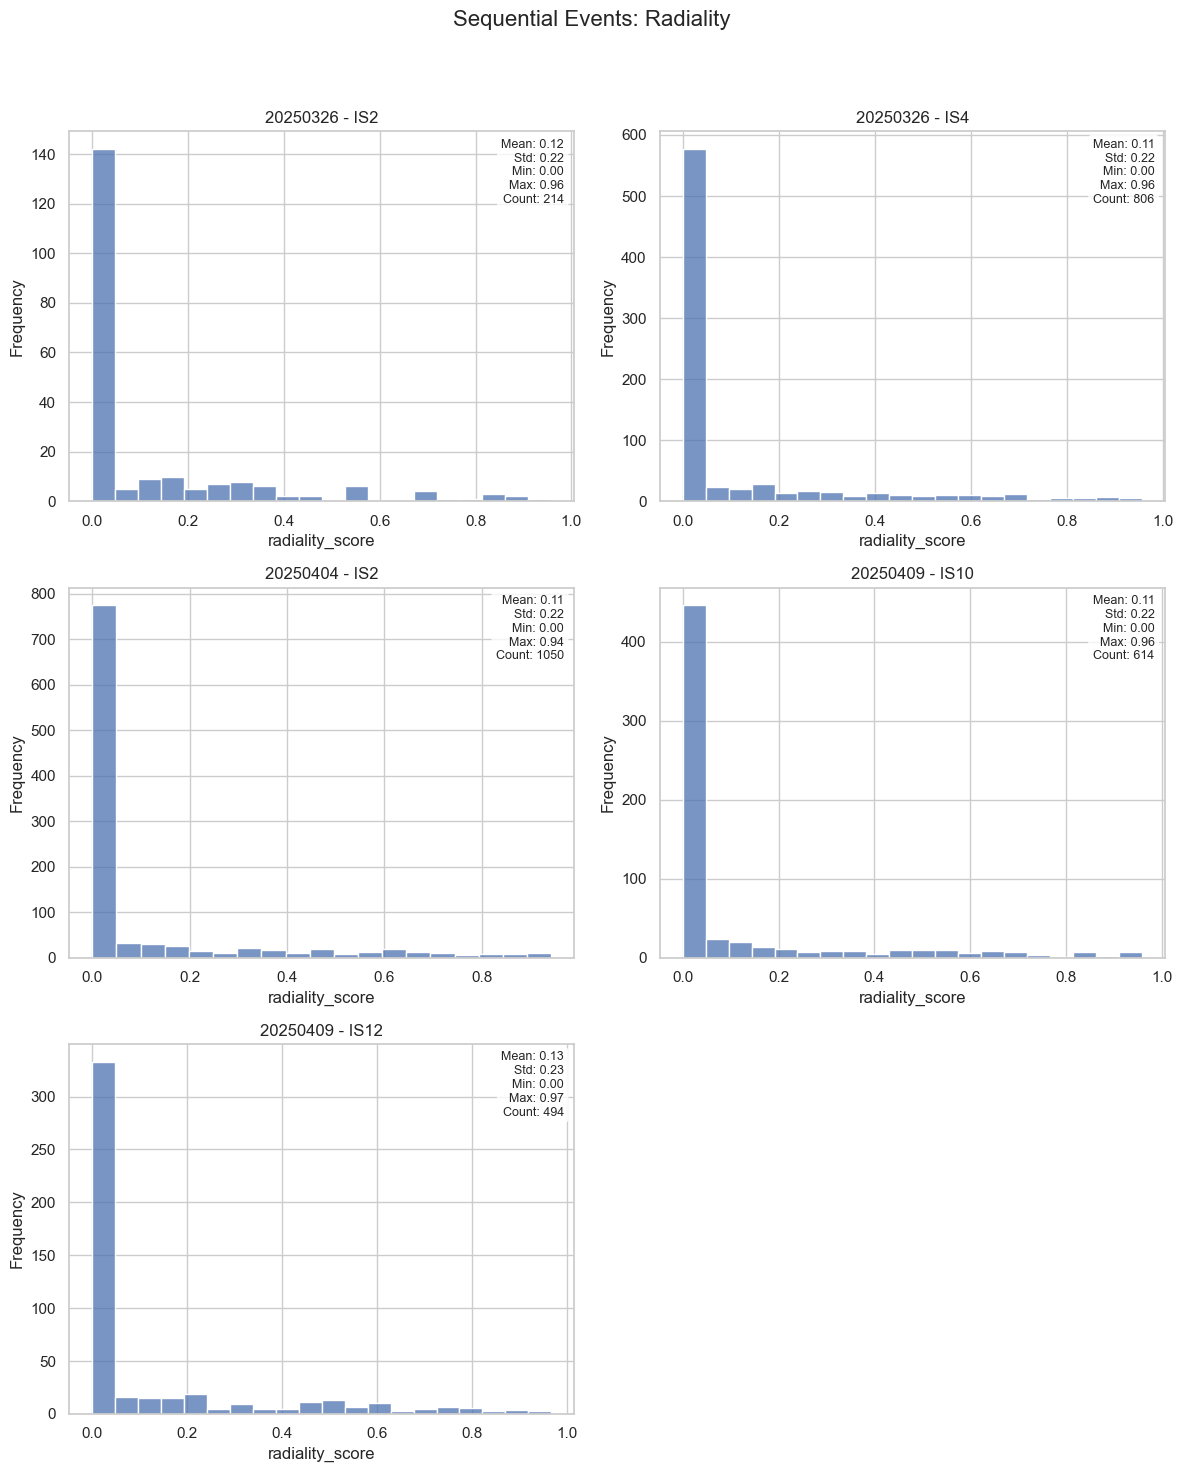

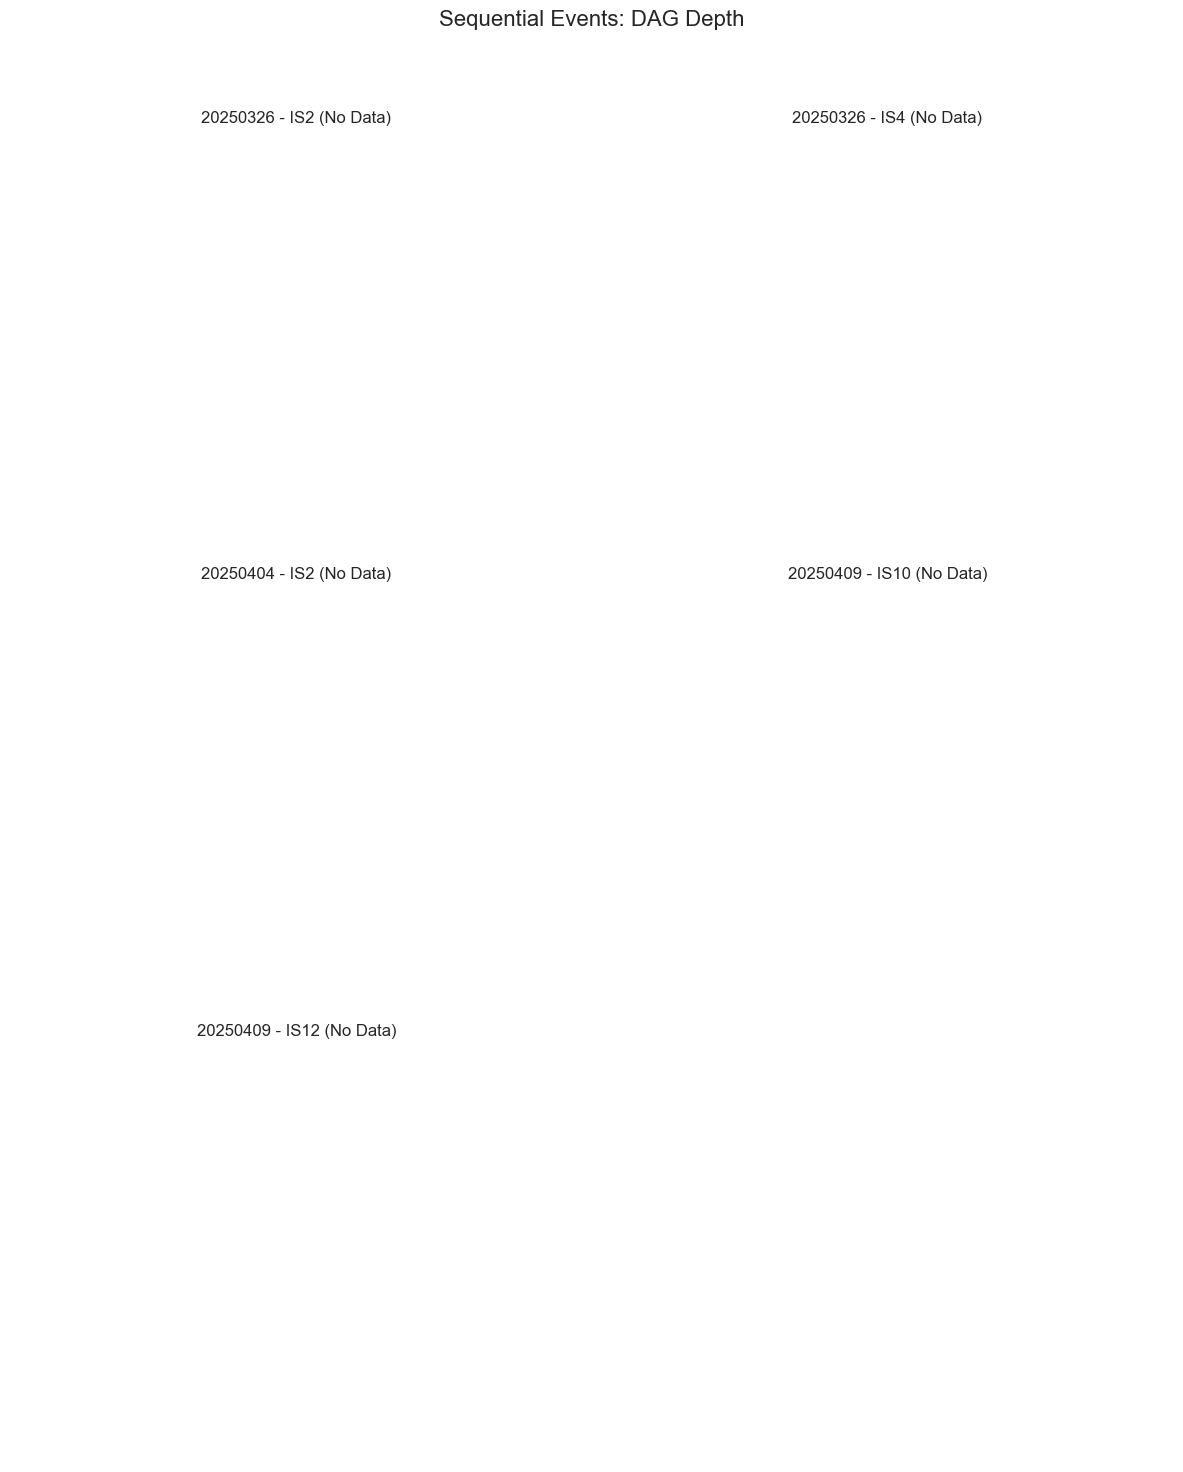

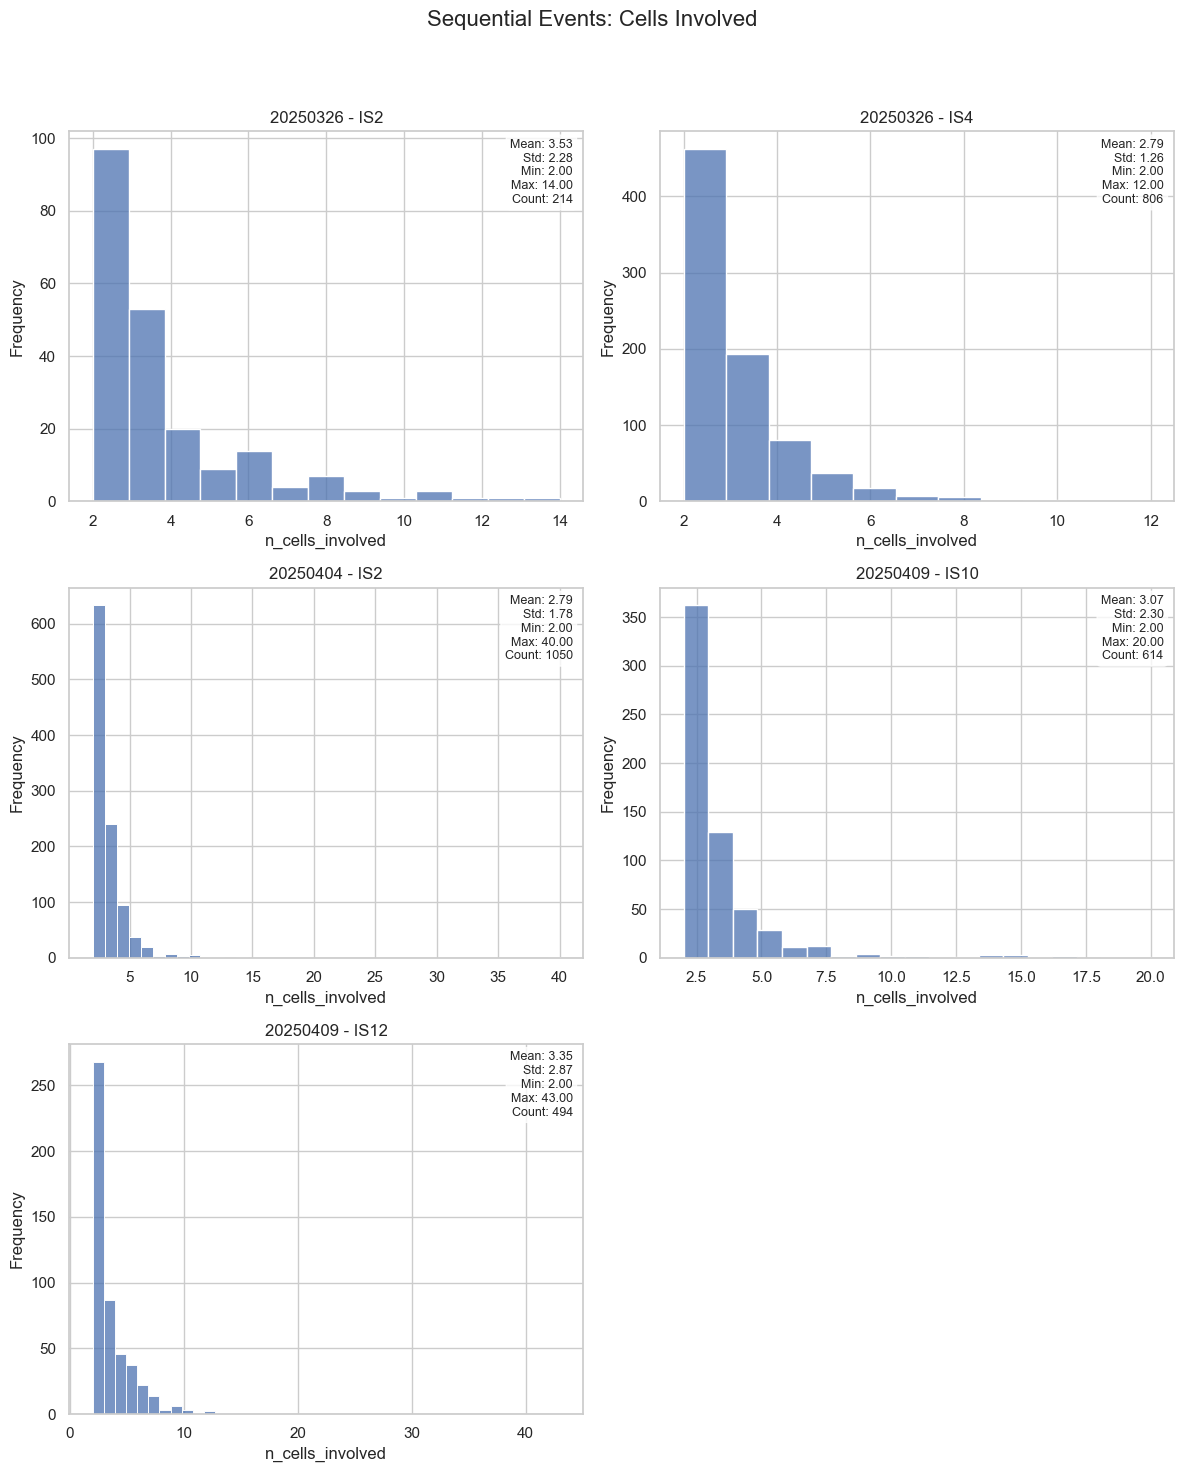

In [8]:
seq_events = events[events["event_type"] == "SequentialEvent"]
plot_metric_by_dataset(seq_events, "communication_time_mean", "Sequential Events: Comm Time", bin_width=1)
plot_metric_by_dataset(seq_events, "communication_speed_mean", "Sequential Events: Comm Speed", bin_count=50)
plot_metric_by_dataset(seq_events, "elongation_score", "Sequential Events: Elongation", bin_count=50)
plot_metric_by_dataset(seq_events, "radiality_score", "Sequential Events: Radiality", bin_width=0.05)
plot_metric_by_dataset(seq_events, "dag_depth", "Sequential Events: DAG Depth", bin_width=1)
plot_metric_by_dataset(seq_events, "n_cells_involved", "Sequential Events: Cells Involved", bin_width=1)

## 📌 Conclusion & Next Steps

After a detailed comparison between the **first** and **second imaging runs** of spontaneous calcium activity in BxPC3 cells, we conclude that the **second run cannot be considered valid control data** for downstream analyses.

The second run shows a **complete absence of global paracrine events** in almost all datasets, a sharp contrast to the first run where such events consistently accounted for ~30–40% of peaks. This loss of global coordination is accompanied by:

- A **significant decrease in the number of active cells**
- **Reduced total number of peaks per dataset**
- A **shift in distribution** of cell activity metrics, including a transition toward exponential decay patterns
- **Slightly longer durations** of individual and sequential peaks, potentially reflecting altered event dynamics
- **Preserved periodicity and symmetry**, suggesting that although overall activity is suppressed, underlying temporal regulation is still intact

These observations are strongly suggestive of **phototoxic damage**, **photobleaching**, and/or **cellular stress** due to environmental conditions (room temperature, lack of CO₂ and humidity) during the extended imaging protocol. One dataset (`2025-04-04 IS3`) did retain global activity and matched the first run in active cell fraction, reinforcing the likelihood that these effects are **time- and condition-dependent**.

---

### 🔒 Decision

- ✅ **First run datasets** are retained as reliable control data.
- ❌ **Second run datasets** will be excluded from all future analyses due to significant biological drift.

---

### 🔮 Next Steps

- Investigate the **event-specific activation** of cells — particularly whether inactive cells in the second run are reactivated only during large-scale events.
- Consider building metrics to quantify **cell participation by event type** (e.g., proportion of cells involved in global vs. sequential events).
- Implement stricter protocols for time control and environmental maintenance between consecutive imaging sessions to avoid reproducibility issues.

---
